<a href="https://colab.research.google.com/github/fberetta8/ML_in_Finance_Spring_2025_ETH/blob/main/Solution9_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pricing and Hedging in LSV models via Neural Networks
This notebook demonstrates how to train a neural network to model local stochastic volatility and hedging strategies for options pricing.
This notebook is heavily inspired by the work of Josef Teichmann and Florian Krach in [this lecture](https://gist.github.com/jteichma/1f1b56e7a48a4d966cf3eb2cce314857).


In [ ]:
# Install TensorFlow version 2.12.0
!pip install tensorflow==2.12.0

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Input, Dense, Conv2D, Concatenate, Dropout, Subtract, \
                        Flatten, MaxPooling2D, Multiply, Lambda, Add, Dot
from keras import optimizers

from keras.models import Model
from keras.layers import Input
from keras import initializers
from keras.constraints import max_norm
import keras.backend as K

In [ ]:
import keras
keras.utils.set_random_seed(345)

In [ ]:
# Layer dimension and parameters

m = 10  # layer dimension
n = 2   # number of layers for local volatility
N = 20  # time discretization (number of steps)
maturities = [0.5, 1.]  # list of maturities
T = 1.0  # total time

In [ ]:
#  Define Local Volatility Layers

layers = []
for j in range(len(maturities)):
    layersatT = []
    for i in range(n):
        if i < n-1:
            nodes = m
        else:
            nodes = 1
        layer = Dense(nodes, activation='relu', trainable=False,
                      kernel_initializer=initializers.RandomNormal(0, 1),
                      bias_initializer='random_normal')
        layersatT = layersatT + [layer]
    layers = layers + [layersatT]

In [ ]:
# Define Hedging Layers

P = {(0.9, 0.5): 0.20042534,
    (0.9, 1.0): 0.23559685,
    (1.0, 0.5): 0.16312157,
    (1.0, 1.0): 0.20771958,
    (1.1, 0.5): 0.13154241,
    (1.1, 1.0): 0.18236567}

hedges = {}
for key in P.keys():
    hedgeskey =[]
    for j in range(N):
        nodes = 1
        hedge = Dense(nodes, activation='relu', trainable=True,
                      kernel_initializer=initializers.RandomNormal(0, 0.1),
                      bias_initializer='random_normal')
        hedgeskey = hedgeskey + [hedge]
    hedges[key] = hedgeskey

In [ ]:
# Training the hedging strategy.

keylist = list(P.keys())
price = Input(shape=(1,))
hedgepf = [Input(shape=(1,)) for l in range(len(P.keys()))]
inputs = [price] + hedgepf
inputshelper = []
hedgeratio = {}
hedge = {}
pricekey = [0 for l in range(len(P.keys()))]

normal = tf.compat.v1.distributions.Normal(loc=0., scale=1.)

def BS(x):
    """
    the Black Scholes Delta Hedge

    key[0]: strike of option
    key[1]: maturity of option
    j: current time step
    """
    price=x[0]
    vola=x[1]
    return normal.cdf((K.log(K.abs(price)/key[0])+0.5*(key[1]-j*T/N)*vola**2)/(0.00001+np.sqrt(key[1]-j*T/N)*vola))
# increases computational time

i = 0  # index of current maturity
for j in range(0,N):  # loop over discrete time steps
    #i=0
    if maturities[i] < j*T/N:  # increase maturity index if time passed the current maturity
        i+=1
    helper0 = layers[i][0](price)  # use localvol NN for maturity i and aggregate all layers
    for k in range(1,n):
        helper0 = layers[i][k](helper0) # localvol applied to price at time j*T/N
    BMincr = Input(shape=(1,)) # stand. normal sample, corresponds to scaled BM increment
    stochvol = Input(shape=(1,)) # stochvol value (alpha)
    helper1 = Multiply()([helper0,BMincr])  # NN_localvol * Normal
    helper1 = Lambda(lambda x: x * np.sqrt(T/N))(helper1)  # NN_localvol * Delta W; (multiply by sqrt(Delta t) to get BM incr)
    priceincr = Multiply()([helper1,stochvol]) # new price increment Delta S; NN_localvol * alpha * Delta W
    for l in range(len(P.keys())):  # go through all options
        key = keylist[l]
        hedgeratio[key] = hedges[key][j](price)  # NN_hedge_strategy takes current price as input and uses the hedging NN specific for the option and the time step
        BSstrategy = Lambda(BS)([price,Multiply()([helper0,stochvol])])  # BS delta hedge strategy applied for current price and vol
        hedgeratio[key] = Add()([hedgeratio[key],BSstrategy])  # use as hedging strategy the BS_strategy + NN_hedge_strategy
        hedge[key] = Multiply()([priceincr,hedgeratio[key]])  # increment of stochastic integral for hedge
        hedgepf[l] = Add()([hedgepf[l],hedge[key]])  # current value of stoch integral for hedge
        if key[1]==((j+1)*T/N): # the option expires
            helper2 = Lambda(lambda x : 0.5*(abs(x-key[0])+x-key[0]))(Add()([price,priceincr]))  # lambda equals max(price - K, 0), use the price at j+1 as input (price+priceincr)
            helper2 = Subtract()([helper2,hedgepf[l]]) # payoff minus hedge
            pricekey[l] = helper2  # model output
    price = Add()([price,priceincr]) # new price after one time step
    inputshelper = inputshelper + [stochvol]
    inputs = inputs + [BMincr]

inputs = inputs + inputshelper  # help to sort the inputs (first all BMincr then all stochvol)
pricekey = Concatenate()(pricekey)
localvol_trainhedge = Model(inputs=inputs, outputs=pricekey)

<ipython-input-20-668f09db2eb7>:24: RuntimeWarning: invalid value encountered in sqrt
  return normal.cdf((K.log(K.abs(price)/key[0])+0.5*(key[1]-j*T/N)*vola**2)/(0.00001+np.sqrt(key[1]-j*T/N)*vola))


In [ ]:
# Training the local volatility model

layers = []

for j in range(len(maturities)):
    layersatT = []
    for i in range(2):
        if i < 1:
            nodes = m
        else:
            nodes = 1
        layer = Dense(nodes, activation='relu', trainable=True,  # localvol trainable
                      kernel_initializer=initializers.RandomNormal(0, 1),#kernel_initializer='random_normal',
                      bias_initializer='random_normal')
        layersatT = layersatT + [layer]
    layers = layers + [layersatT]


hedges = {}
for key in P.keys():
    hedgeskey =[]
    for j in range(N):
        nodes = 1
        hedge = Dense(nodes, activation='relu', trainable=False,  # hedges not trainable
                      kernel_initializer=initializers.RandomNormal(0,0.1),#kernel_initializer='random_normal',
                      bias_initializer='random_normal')
        hedgeskey = hedgeskey + [hedge]
    hedges[key] = hedgeskey
start = 0

keylist = list(P.keys())
price = Input(shape=(1,))
hedgepf = [Input(shape=(1,)) for l in range(len(P.keys()))]
inputs = [price] + hedgepf
inputshelper = []
hedgeratio = {}
hedge = {}
pricekey = [0 for l in range(len(P.keys()))]

i = 0  # index of current maturity
for j in range(0,N):  # loop over discrete time steps
    #i=0
    if maturities[i] < j*T/N:  # increase maturity index if time passed the current maturity
        i+=1
    helper0 = layers[i][0](price)  # use localvol NN for maturity i and aggregate all layers
    for k in range(1,n):
        helper0 = layers[i][k](helper0) # localvol applied to price at time j*T/N
    BMincr = Input(shape=(1,)) # stand. normal sample, corresponds to scaled BM increment
    stochvol = Input(shape=(1,)) # stochvol value (alpha)
    helper1 = Multiply()([helper0,BMincr])  # NN_localvol * Normal
    helper1 = Lambda(lambda x: x * np.sqrt(T/N))(helper1)  # NN_localvol * Delta W; (multiply by sqrt(Delta t) to get BM incr)
    priceincr = Multiply()([helper1,stochvol]) # new price increment Delta S; NN_localvol * alpha * Delta W
    for l in range(len(P.keys())):  # go through all options
        key = keylist[l]
        hedgeratio[key] = hedges[key][j](price)  # NN_hedge_strategy takes current price as input and uses the hedging NN specific for the option and the time step
        BSstrategy = Lambda(BS)([price,Multiply()([helper0,stochvol])])  # BS delta hedge strategy applied for current price and vol
        hedgeratio[key] = Add()([hedgeratio[key],BSstrategy])  # use as hedging strategy the BS_strategy + NN_hedge_strategy
        hedge[key] = Multiply()([priceincr,hedgeratio[key]])  # increment of stochastic integral for hedge
        hedgepf[l] = Add()([hedgepf[l],hedge[key]])  # current value of stoch integral for hedge
        if key[1]==((j+1)*T/N): # the option expires
            helper2 = Lambda(lambda x : 0.5*(abs(x-key[0])+x-key[0]))(Add()([price,priceincr]))  # lambda equals max(price - K, 0), use the price at j+1 as input (price+priceincr)
            helper2 = Subtract()([helper2,hedgepf[l]]) # payoff minus hedge
            pricekey[l] = helper2  # model output
    price = Add()([price,priceincr]) # new price after one time step
    inputshelper = inputshelper + [stochvol]
    inputs = inputs + [BMincr]

inputs = inputs + inputshelper  # help to sort the inputs (first all BMincr then all stochvol)
pricekey = Concatenate()(pricekey)
localvol_trainlocvol = Model(inputs=inputs, outputs=pricekey)

<ipython-input-20-668f09db2eb7>:24: RuntimeWarning: invalid value encountered in sqrt
  return normal.cdf((K.log(K.abs(price)/key[0])+0.5*(key[1]-j*T/N)*vola**2)/(0.00001+np.sqrt(key[1]-j*T/N)*vola))


In [ ]:
# Training Setup and Loss function

# Number of training samples
Ltrain = 5 * 10**3

# Create training data: inputs and targets
xtrain = ([np.ones(Ltrain)] + [np.zeros(Ltrain) for key in keylist] +
          [np.random.normal(0, 1, Ltrain) for i in range(N)] +
          [np.ones(Ltrain) for i in range(N)])

ytrain = np.array(list(P.values())).reshape((1, -1)).repeat(Ltrain, axis=0)

def localvol_loss_fn(y_true, y_pred):
    return K.mean(K.square(K.mean(y_pred, axis=0) - K.mean(y_true, axis=0)))

In [ ]:
# Compile the models

localvol_trainhedge.compile(optimizer='adam', loss='mean_squared_error')
localvol_trainlocvol.compile(optimizer='adam', loss=localvol_loss_fn)

In [ ]:
# Training loop

for k in range(3):
    # Fit the hedging model
    localvol_trainhedge.fit(x=xtrain, y=ytrain, epochs=10, verbose=True)

    # Transfer weights from hedge model to local volatility model
    x = localvol_trainhedge.get_weights()
    localvol_trainlocvol.set_weights(x)

    # Fit the local volatility model
    localvol_trainlocvol.fit(x=xtrain, y=ytrain, epochs=15, verbose=True, batch_size=Ltrain)

    # Plot predictions
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    predictions = localvol_trainlocvol.predict(xtrain)
    axs[0].hist(predictions[:, 0])  # plot distribution of the first model option price
    axs[1].hist(predictions[:, :])  # plot distribution of all model option prices
    plt.show()

    # Print model values and target values
    print("Model values: ", list(np.mean(predictions, axis=0)))
    print("Target values:", list(P.values()))

    # Transfer weights from the local volatility model to the hedge model
    y = localvol_trainlocvol.get_weights()
    localvol_trainhedge.set_weights(y)

31250/31250 [==============================] - 276s 9ms/step


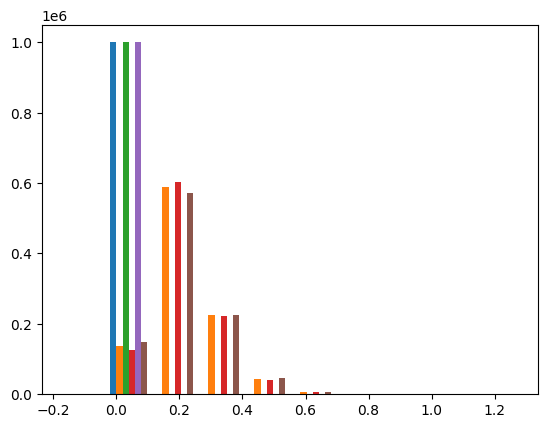

Calibrated values: [0.0, 0.21368366, 0.0, 0.21371496, 0.0, 0.21372789]
Ground truth:      [0.20042534, 0.23559685, 0.16312157, 0.20771958, 0.13154241, 0.18236567]


In [ ]:
# Testing environment

# Number of test samples
Ltest = 10**6

# Create test data: inputs and targets
xtest = ([np.ones(Ltest)] + [np.zeros(Ltest) for key in keylist] +
         [np.random.normal(0, 1, Ltest) for i in range(N)] +
         [np.ones(Ltest) for i in range(N)])

ytest = np.array(list(P.values())).reshape((1, -1)).repeat(Ltest, axis=0)

# Generate predictions for test data
predictions = localvol_trainlocvol.predict(xtest)

# Plot test predictions
plt.hist(predictions[:,:])
plt.show()

# Print calibrated values and ground truth
print('Calibrated values:', list(np.mean(predictions, axis=0)))
print('Ground truth:     ', list(P.values()))